### Lets compare a standard Nevot-Croce model with VFP model

Starting with module imports

In [1]:
import sys
import os

sys.path.append(os.getcwd())

import numpy as np
import refnx
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective, Parameter
from refnx.reflect import SLD, ReflectModel, MixedReflectModel, Slab, Structure
import scipy
import periodictable
import matplotlib.pyplot as plt

from VFP import VFP

We can just use a simple model for these purposes...

In [25]:
#SLDs
Si = SLD(2.07, name='Si')
SiO2 = SLD(3.47, name='SiO2')
Surfactant = SLD(0.1, name='Surf')
D2O = SLD(6.37, name='D2O')

In [26]:
#layers

SiO2_lay = SiO2(20, 3)

Surf_lay = Surfactant(50, 3)

D2O_lay = D2O(0, 5)

In [27]:
# structure

simple_struc = Si | SiO2_lay | Surf_lay | D2O_lay 

In [28]:
# model

simple_model = ReflectModel(simple_struc, scale=1, bkg=1e-6, dq=3*2.355)

### Create a second model with VFP

In [37]:
### list up the thicknesses, roughnesses and slds to send to the vfp.

list_of_thickness = (0, SiO2_lay.thick, Surf_lay.thick) #first must be zero for Si thickness.
list_of_roughness = (SiO2_lay.rough, Surf_lay.rough, D2O_lay.rough)

In [38]:
"""
The nSLDs are ordered as the following:
Si, SiO2, Surfactant, D2O
"""

#these values can come from the layers defined above, the SLD objects above or some function of them.
nuclear_SLDs = np.array([Si.real, SiO2_lay.sld.real, Surf_lay.sld.real, D2O_lay.sld.real])

#won't bother modelling any imaginary SLDs, but do need to declare them.
nuclear_iSLDs = np.array([0, 0, 0, 0])

#similar with magnetic SLDs.
magnetic_SLDs = np.array([0, 0, 0, 0])

In [39]:
# create the extent parameter that describes how long the volume fraction profile is.

VFP_tot = Parameter(name='VFP_tot', constraint=5+(4 * 3)+SiO2_lay.thick+Surf_lay.thick+5+(4 * D2O_lay.rough))

In [40]:
# now define the VFP
d2o_vfp = VFP(extent=VFP_tot, 
              nSLDs=nuclear_SLDs, 
              niSLDs=nuclear_iSLDs, 
              mSLDs = magnetic_SLDs, 
              thicknesses=list_of_thickness,
              roughnesses=list_of_roughness, 
              contrast='D2O')

In [41]:
#wrap the vfp between the fronting and backing SLDs (not layers!)
d2o_struct = Si | d2o_vfp | D2O

In [42]:
VFP_model = ReflectModel(d2o_struct, scale=1, bkg=1e-6, dq=3*2.355)

### Now lets compare

Text(0.5, 0, '$Q$ / $\\mathrm{\\AA{}}^{-1}$')

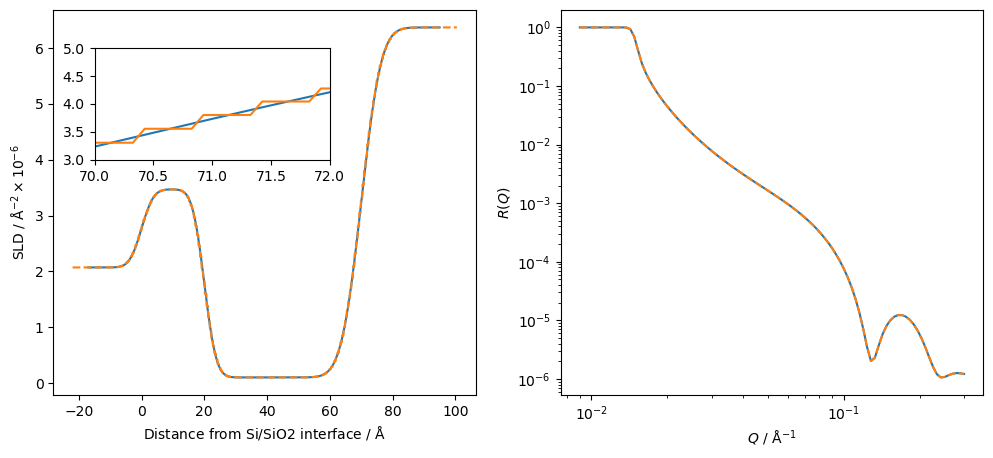

In [76]:
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(*simple_model.structure.sld_profile())
ax[0].plot(VFP_model.structure.sld_profile(max_delta_z=0.1)[0]-(5+4*3), 
           VFP_model.structure.sld_profile(max_delta_z=0.1)[1],
           linestyle='--')
ax[0].set_xlabel(r'Distance from Si/SiO2 interface / $\mathrm{\AA}$')
ax[0].set_ylabel(r'$\mathrm{SLD}$ / $\mathrm{\AA{}}^{-2} \times 10^{-6}$')

axins = ax[0].inset_axes([-15, 4, 75, 2], transform=ax[0].transData)
axins.plot(*simple_model.structure.sld_profile())
axins.plot(VFP_model.structure.sld_profile(max_delta_z=0.1)[0]-(5+4*3), 
           VFP_model.structure.sld_profile(max_delta_z=0.1)[1])
axins.set_xlim(70, 72)
axins.set_ylim(3, 5)

Q = np.geomspace(9E-3, 3E-1, 100)
ax[1].plot(Q, simple_model.model(x=Q))
ax[1].plot(Q, VFP_model.model(x=Q), linestyle='--')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylabel(r'$R\left(Q\right)$')
ax[1].set_xlabel(r'$Q$ / $\mathrm{\AA{}}^{-1}$')

### can re-create a nevot-croce model using the VFP.

The inset on the LHS plot above shows the microslab approximation of the continuous SLD profile.